In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str('mnist'))

In [3]:
def cnn_mnist(input_shape, min_val, max_val):
  
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                model=model, use_logits=False)
    return classifier

In [4]:
num_epochs = 10

classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





468/468 [==============================] - 29s 62ms/step - loss: 0.2227 - acc: 0.9355
Epoch 2/10
468/468 [==============================] - 29s 61ms/step - loss: 0.0609 - acc: 0.9813
Epoch 3/10
468/468 [==============================] - 26s 56ms/step - loss: 0.0451 - acc: 0.9866
Epoch 4/10
468/468 [==============================] - 26s 55ms/step - loss: 0.0333 - acc: 0.9894
Epoch 5/10
468/468 [==============================] - 26s 55ms/step - loss: 0.0276 - acc: 0.9915
Epoch 6/10
468/468 [==============================] - 26s 55ms/step - loss: 0.0249 - acc: 0.9924
Epoch 7/10
468/468 [==============================] - 25s 54ms/step - loss: 0.0201 - acc: 0.9936
Epoch 8/10
468/468 [==============================] - 26s 55ms/step - loss: 0.0178 - acc: 0.9942


In [5]:
attack = MIFace(classifier, max_iter=10000, threshold=1.) 

In [6]:
y = np.arange(10)

In [7]:
x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

In [8]:
print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.013524


In [9]:
class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.012113


In [10]:
%%time
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 6min 28s, sys: 30.7 s, total: 6min 58s
Wall time: 5min 38s


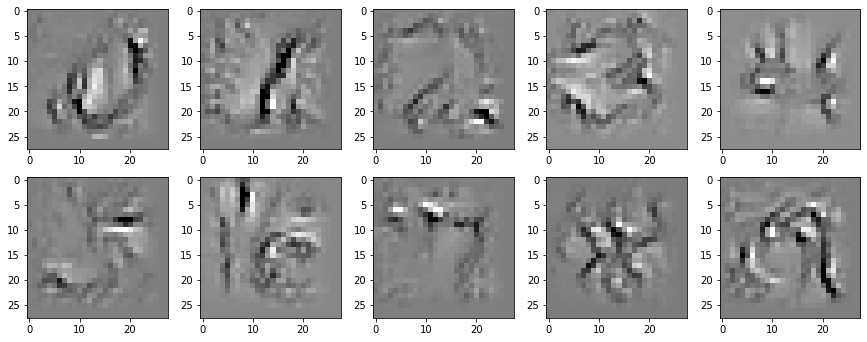

In [11]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (28, 28))), cmap=plt.cm.gray_r)

In [12]:
class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.003922


In [13]:
%%time

x_infer_from_black = attack.infer(x_init_black, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 6min 27s, sys: 30.8 s, total: 6min 58s
Wall time: 5min 34s


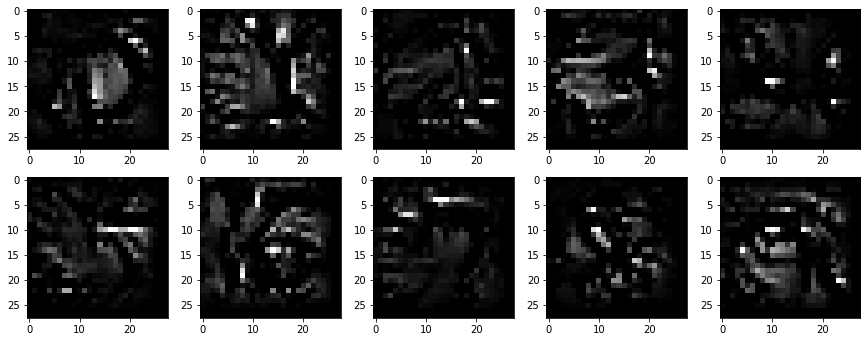

In [14]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (28, 28))), cmap=plt.cm.gray_r)

In [15]:
class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.003138


In [16]:
%%time

x_infer_from_random = attack.infer(x_init_random, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 6min 29s, sys: 30.2 s, total: 6min 59s
Wall time: 5min 35s


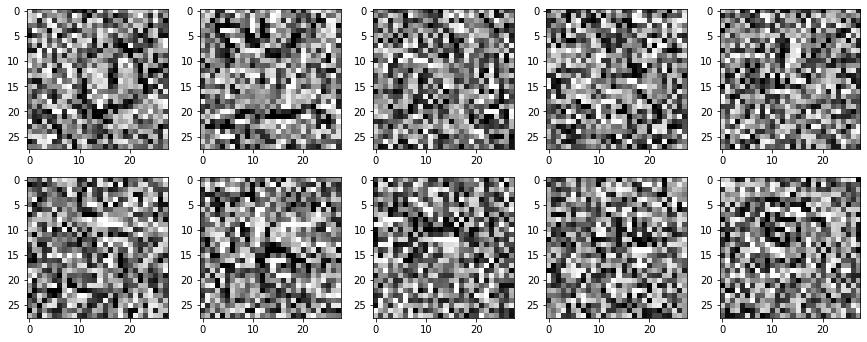

In [17]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (28, 28))), cmap=plt.cm.gray_r)

In [18]:
class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.024879


In [19]:
%%time
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 6min 25s, sys: 30.5 s, total: 6min 56s
Wall time: 5min 33s


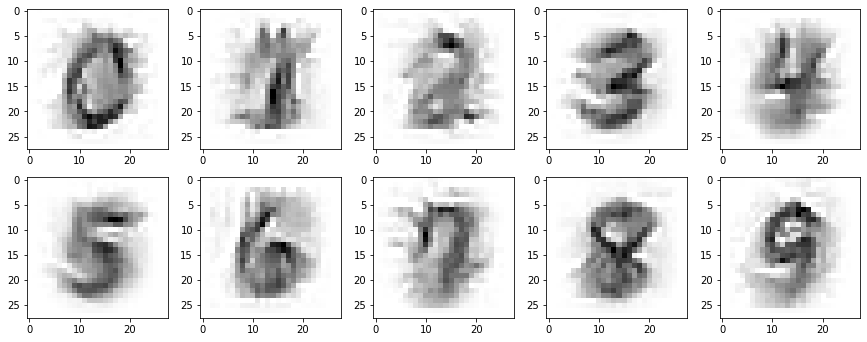

In [20]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (28, 28))), cmap=plt.cm.gray_r)